# Developing of the pipeline

In [46]:
from data_loaders import get_data_module
from utils.visualisation import showInRow

import torch
from torch import nn
from torch.optim import SGD
from torch.utils.data import DataLoader
import pytorch_lightning as pl
from pytorch_lightning import seed_everything
import torchvision.models as models
from torchvision import transforms
from pytorch_lightning.loggers import WandbLogger
import random
import torchvision
import torch.nn.functional as F
from PIL import ImageFilter
from pl_bolts.metrics import mean
seed_everything(123456)

from pl_bolts.models.self_supervised import MocoV2

# Define transformations for MOCO+Chest X-rays

In [2]:
class Moco2TrainChestTransforms:
    """
    Moco 2 modified  augmentation:
    Classic: https://arxiv.org/pdf/2003.04297.pdf
    Chest:   https://arxiv.org/pdf/2010.05352v1.pdf
    """

    def __init__(self, height: int = 128):
        # image augmentation functions
        self.train_transform = transforms.Compose([
            transforms.Resize((height,height)),
            transforms.RandomHorizontalFlip(),
            transforms.RandomRotation(10),
            transforms.ToTensor()
            # TODO: think about normalisation
        ])

    def __call__(self, inp):
        q = self.train_transform(inp).contiguous()
        k = self.train_transform(inp).contiguous()
        return q, k

# Define datamodule

## Check that data augmentations are good

Batch 4


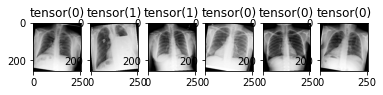

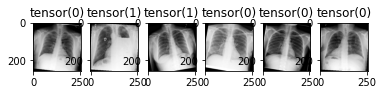

Batch 3


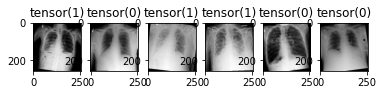

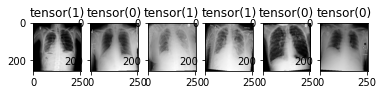

Batch 2


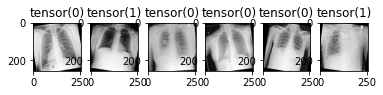

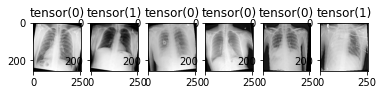

Batch 1


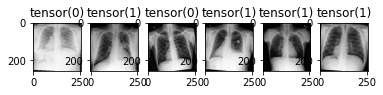

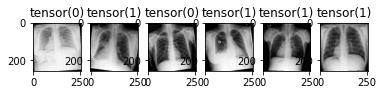

Batch 0


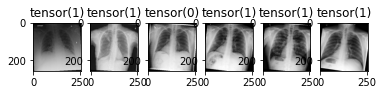

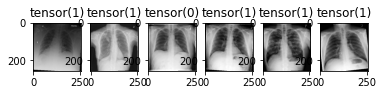

In [4]:
moco_chest_transform = Moco2TrainChestTransforms(height=256)
data_module = get_data_module("Chest14", transform=moco_chest_transform, batch_size=6)
batches = 4
for batch in data_module.train_dataloader():
    (img1, img2), labels = batch["image"],batch['label']
    print("Batch", batches)
    showInRow(img1, labels, tensor=True)
    showInRow(img2, labels, tensor=True)
    batches -=  1
    if batches<0:
        break

In [5]:
from pl_bolts.models.self_supervised.moco.moco2_module import precision_at_k

class pretrainedMocoV2(MocoV2):
    def __init__(self, pretrained:bool=False,**kwargs):
        self.pretrained=pretrained
        super().__init__(**kwargs)
        
    def init_encoders(self, base_encoder):
        template_model = getattr(torchvision.models, base_encoder)
        if self.pretrained:
            print("Loading pretrained",base_encoder,"model")
            # Load pretrained model
            encoder_q = template_model(pretrained=True)
            encoder_k = template_model(pretrained=True)
            
            # Substitute last layer with correct one
            encoder_q.fc = nn.Linear(512, self.hparams.emb_dim)
            encoder_k.fc = nn.Linear(512, self.hparams.emb_dim)
        else:
            print("Loading",base_encoder,"model without pretraining")
            encoder_q = template_model(num_classes=self.hparams.emb_dim)
            encoder_k = template_model(num_classes=self.hparams.emb_dim)
        return encoder_q, encoder_k
    
    def training_step(self, batch, batch_idx):

        (img_1, img_2) = batch["image"]

        output, target = self(img_q=img_1, img_k=img_2)
        loss = F.cross_entropy(output.float(), target.long())

        acc1, acc5 = precision_at_k(output, target, top_k=(1, 5))

        log = {
            'train_loss': loss,
            'train_acc1': acc1,
            'train_acc5': acc5
        }
        self.log_dict(log)
        return loss

    def validation_step(self, batch, batch_idx):

        (img_1, img_2), labels = batch["image"], batch["label"]

        output, target = self(img_q=img_1, img_k=img_2)
        loss = F.cross_entropy(output, target.long())

        acc1, acc5 = precision_at_k(output, target, top_k=(1, 5))

        results = {
            'val_loss': loss,
            'val_acc1': acc1,
            'val_acc5': acc5
        }
        return results

In [20]:
data_module = get_data_module("Chest14", transform=moco_chest_transform, batch_size=8)
my_moco = pretrainedMocoV2(
           pretrained = True,
           base_encoder="resnet18", 
           num_negatives=65536,
           batch_size=8,
           num_workers=2,
           datamodule=data_module,
           learning_rate=1e-4)

Loading pretrained resnet18 model


In [21]:
wandb_logger = WandbLogger(name='SGD-0.0001',project='pytorchlightning')
trainer = pl.Trainer(gpus=1, deterministic=True, logger=wandb_logger, max_epochs=1)


if torch.cuda.is_available():
    my_moco = my_moco.cuda()

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


In [22]:
trainer.fit(my_moco, data_module)

wandb: WARNING Calling wandb.login() after wandb.init() has no effect.


train_loss,1.21328
train_acc1,100.0
train_acc5,100.0
epoch,0
_step,399
_runtime,45
_timestamp,1605629187


train_loss,▁▂▂▅▁▂▂█
train_acc1,▁▁▁▁▁▁▁▁
train_acc5,▁▁▁▁▁▁▁▁
epoch,▁▁▁▁▁▁▁▁
_step,▁▂▃▄▅▆▇█
_runtime,▁▂▃▃▄▅▆█
_timestamp,▁▂▃▃▄▅▆█


wandb: wandb version 0.10.10 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade



  | Name      | Type   | Params
-------------------------------------
0 | encoder_q | ResNet | 11 M  
1 | encoder_k | ResNet | 11 M  


1

In [14]:
my_moco.hparams.batch_size

8

In [73]:
class BasicClassifier(pl.LightningModule):
    def __init__(self, model, num_classes, learning_rate=1e-4,momentum=0.9,weight_decay=1e-4,
                 linear=False,*args, **kwargs):
        super().__init__()
        self.save_hyperparameters()
        self.model = model
        self.model.fc = nn.Linear(512, num_classes)
        # Freeze everething but classifier
        if linear:
            layer_num = 0
            for child in self.model.children():
                layer_num +=1
                if layer_num < 10:
                    for param in child.parameters():
                        param.requires_grad = False
        self.accuracy = pl.metrics.Accuracy()
        
    def forward(self, x):
        return self.model(x) 
    
    def training_step(self, batch, batch_nb):
        x, target = batch["image"], batch["label"]
        preds = self(x)
        loss = F.cross_entropy(preds, target)
        acc = self.accuracy(preds, target)
        log = {
            'train_loss': loss,
            'train_acc': acc
        }
        self.log_dict(log)
        
        return loss
    
    def validation_step(self, batch, batch_idx):
        x, target = batch["image"], batch["label"]

        preds = self(x)
        loss = F.cross_entropy(preds, target)
        acc = self.accuracy(preds, target)


        results = {
            'val_loss': loss,
            'val_acc': acc
        }
        return results

    def validation_epoch_end(self, outputs):
        val_loss = mean(outputs, 'val_loss')
        val_acc = mean(outputs, 'val_acc')

        log = {
            'val_loss': val_loss,
            'val_acc': val_acc,
        }
        self.log_dict(log)
    
    def configure_optimizers(self):
        optimizer = torch.optim.SGD(self.parameters(), self.hparams.learning_rate,
                                    momentum=self.hparams.momentum,
                                    weight_decay=self.hparams.weight_decay)
        scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=20, gamma=0.1)
        return [optimizer], [scheduler]

In [74]:
classifier = BasicClassifier(my_moco.encoder_q, num_classes=2, linear=True)

In [75]:
wandb_logger = WandbLogger(name='ft-SGD-0.0001',project='pytorchlightning')
trainer = pl.Trainer(gpus=1, deterministic=True, logger=wandb_logger, max_epochs=1)


if torch.cuda.is_available():
    classifier = classifier.cuda()

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


In [76]:
transform=transforms.Compose([transforms.Resize((256,256)),
                                transforms.RandomHorizontalFlip(),
                                transforms.RandomRotation(10),
                                transforms.ToTensor()
                             ])
data_module = get_data_module("Chest14", transform=transform, batch_size=8)

In [77]:
trainer.fit(classifier, data_module)

wandb: WARNING Calling wandb.login() after wandb.init() has no effect.


wandb: wandb version 0.10.10 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade



  | Name     | Type     | Params
--------------------------------------
0 | model    | ResNet   | 11 M  
1 | accuracy | Accuracy | 0     
/opt/conda/lib/python3.7/site-packages/pytorch_lightning/utilities/distributed.py:45: UserWarning: The dataloader, val dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 32 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  warnings.warn(*args, **kwargs)


/opt/conda/lib/python3.7/site-packages/pytorch_lightning/utilities/distributed.py:45: UserWarning: The dataloader, train dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 32 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  warnings.warn(*args, **kwargs)


/opt/conda/lib/python3.7/site-packages/pytorch_lightning/utilities/distributed.py:45: UserWarning: Detected KeyboardInterrupt, attempting graceful shutdown...
  warnings.warn(*args, **kwargs)


1